# Notebook 13: Using Deep Learning to Study SUSY with Pytorch

## Learning Goals
The goal of this notebook is to introduce the powerful PyTorch framework for building neural networks and use it to analyze the SUSY dataset. After this notebook, the reader should understand the mechanics of PyTorch and how to construct DNNs using this package. In addition, the reader is encouraged to explore the GPU backend available in Pytorch on this dataset.

## Overview
In this notebook, we use Deep Neural Networks to classify the supersymmetry dataset, first introduced by Baldi et al. in [Nature Communication (2015)](https://www.nature.com/articles/ncomms5308). The SUSY data set consists of 5,000,000 Monte-Carlo samples of supersymmetric and non-supersymmetric collisions with $18$ features. The signal process is the production of electrically-charged supersymmetric particles which decay to $W$ bosons and an electrically-neutral supersymmetric particle that is invisible to the detector.

The first $8$ features are "raw" kinematic features that can be directly measured from collisions. The final $10$ features are "hand constructed" features that have been chosen using physical knowledge and are known to be important in distinguishing supersymmetric and non-supersymmetric collision events. More specifically, they are given by the column names below.

In this notebook, we study this dataset using Pytorch.

In [2]:
from __future__ import print_function, division
import os,sys
import numpy as np
import torch # pytorch package, allows using GPUs
# fix seed
seed=17
np.random.seed(seed)
torch.manual_seed(seed)

## Structure of the Procedure

Constructing a Deep Neural Network to solve ML problems is a multiple-stage process. Quite generally, one can identify the key steps as follows:

* ***step 1:*** Load and process the data
* ***step 2:*** Define the model and its architecture
* ***step 3:*** Choose the optimizer and the cost function
* ***step 4:*** Train the model 
* ***step 5:*** Evaluate the model performance on the *unseen* test data
* ***step 6:*** Modify the hyperparameters to optimize performance for the specific data set

Below, we sometimes combine some of these steps together for convenience.

Notice that we take a rather different approach, compared to the simpler MNIST Keras notebook. We first define a set of classes and functions and run the actual computation only in the very end.

### Step 1: Load and Process the SUSY Dataset

The supersymmetry dataset can be downloaded from the UCI Machine Learning repository on [https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz](https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz). The dataset is quite large. Download the dataset and unzip it in a directory.

Loading data in Pytroch is done by creating a user-defined a class, which we name `SUSY_Dataset`, and is a child of the `torch.utils.data.Dataset` class. This ensures that all necessary attributes required for the processing of the data during the training and test stages are easily inherited. The `__init__` method of our custom data class should contain the usual code for loading the data, which is problem-specific, and has been discussed for the SUSY data set in Notebook 5. More importantly, the user-defined data class must override the `__len__` and `__getitem__` methods of the parent `DataSet` class. The former returns the size of the data set, while the latter allows the user to access a particular data point from the set by specifying its index.

In [2]:
from torchvision import datasets # load data

class SUSY_Dataset(torch.utils.data.Dataset):
    """SUSY pytorch dataset."""

    def __init__(self, data_file, root_dir, dataset_size, train=True, transform=None, high_level_feats=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            train (bool, optional): If set to `True` load training data.
            transform (callable, optional): Optional transform to be applied on a sample.
            high_level_festures (bool, optional): If set to `True`, working with high-level features only. 
                                        If set to `False`, working with low-level features only.
                                        Default is `None`: working with all features
        """

        import pandas as pd

        features=['SUSY','lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
                'missing energy magnitude', 'missing energy phi', 'MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2', 
                'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']

        low_features=['lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
                'missing energy magnitude', 'missing energy phi']

        high_features=['MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2','S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']


        #Number of datapoints to work with
        df = pd.read_csv(root_dir+data_file, header=None,nrows=dataset_size,engine='python')
        df.columns=features
        Y = df['SUSY']
        X = df[[col for col in df.columns if col!="SUSY"]]

        # set training and test data size
        train_size=int(0.8*dataset_size)
        self.train=train

        if self.train:
            X=X[:train_size]
            Y=Y[:train_size]
            print("Training on {} examples".format(train_size))
        else:
            X=X[train_size:]
            Y=Y[train_size:]
            print("Testing on {} examples".format(dataset_size-train_size))


        self.root_dir = root_dir
        self.transform = transform

        # make datasets using only the 8 low-level features and 10 high-level features
        if high_level_feats is None:
            self.data=(X.values.astype(np.float32),Y.values.astype(int))
            print("Using both high and low level features")
        elif high_level_feats is True:
            self.data=(X[high_features].values.astype(np.float32),Y.values.astype(int))
            print("Using both high-level features only.")
        elif high_level_feats is False:
            self.data=(X[low_features].values.astype(np.float32),Y.values.astype(int))
            print("Using both low-level features only.")


    # override __len__ and __getitem__ of the Dataset() class

    def __len__(self):
        return len(self.data[1])

    def __getitem__(self, idx):

        sample=(self.data[0][idx,...],self.data[1][idx])

        if self.transform:
            sample=self.transform(sample)

        return sample

Last, we define a helper function `load_data()` that accepts as a required argument the set of parameters `args`, and returns two generators: `test_loader` and `train_loader` which readily return mini-batches.

In [3]:
def load_data(args):

    data_file='SUSY.csv'
    root_dir=os.path.expanduser('~')+'/ML_review/SUSY_data/'

    kwargs = {} # CUDA arguments, if enabled
    # load and noralise train and test data
    train_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file,root_dir,args.dataset_size,train=True,high_level_feats=args.high_level_feats),
        batch_size=args.batch_size, shuffle=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file,root_dir,args.dataset_size,train=False,high_level_feats=args.high_level_feats),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    return train_loader, test_loader

### Step 2: Define the Neural Net and its Architecture

To construct neural networks with Pytorch, we make another class called `model` as a child of Pytorch's `nn.Module` class. The `model` class initializes the types of layers needed for the deep neural net in its `__init__` method, while the DNN is assembled in a function method called `forward`, which accepts an `autograd.Variable` object and returns the output layer. Using this convention Pytorch will automatically recognize the structure of the DNN, and the `autograd` module will pull the gradients forward and backward using backprop.

Our code below is constructed in such a way that one can choose whether to use the high-level and low-level features separately and altogether. This choice determines the size of the fully-connected input layer `fc1`. Therefore the `__init__` method accepts the optional argument `high_level_feats`. 

In [1]:
import torch.nn as nn # construct NN

class model(nn.Module):
    def __init__(self,high_level_feats=None):
        # inherit attributes and methods of nn.Module
        super(model, self).__init__()

        # an affine operation: y = Wx + b
        if high_level_feats is None:
            self.fc1 = nn.Linear(18, 200) # all features
        elif high_level_feats:
            self.fc1 = nn.Linear(10, 200) # low-level only
        else:
            self.fc1 = nn.Linear(8, 200) # high-level only


        self.batchnorm1=nn.BatchNorm1d(200, eps=1e-05, momentum=0.1)
        self.batchnorm2=nn.BatchNorm1d(100, eps=1e-05, momentum=0.1)

        self.fc2 = nn.Linear(200, 100) # see forward function for dimensions
        self.fc3 = nn.Linear(100, 2)

    def forward(self, x):
        '''Defines the feed-forward function for the NN.

        A backward function is automatically defined using `torch.autograd`

        Parameters
        ----------
        x : autograd.Tensor
            input data

        Returns
        -------
        autograd.Tensor
            output layer of NN

        '''

        # apply rectified linear unit
        x = F.relu(self.fc1(x))
        # apply dropout
        #x=self.batchnorm1(x)
        x = F.dropout(x, training=self.training)


        # apply rectified linear unit
        x = F.relu(self.fc2(x))
        # apply dropout
        #x=self.batchnorm2(x)
        x = F.dropout(x, training=self.training)


        # apply affine operation fc2
        x = self.fc3(x)
        # soft-max layer
        x = F.log_softmax(x,dim=1)

        return x

### Steps 3+4+5: Choose the Optimizer and the Cost Function. Train and Evaluate the Model

Next, we define the function `evaluate_model`. The first argument, `args`, contains all hyperparameters needed for the DNN (see below). The second and third arguments are the `train_loader` and the `test_loader` objects, returned by the function `load_data()` we defined in Step 1 above. The `evaluate_model` function returns the final `test_loss` and `test_accuracy` of the model.

First, we initialize a `model` and call the object `DNN`. In order to define the loss function and the optimizer, we use modules `torch.nn.functional` (imported here as `F`) and `torch.optim`. As a loss function we choose the negative log-likelihood, and stored is under the variable `criterion`. As usual, we can choose any from a variety of different SGD-based optimizers, but we focus on the traditional SGD.

Next, we define two functions: `train()` and `test()`. They are called at the end of `evaluate_model` where we loop over the training epochs to train and test our model. 

The `train` function accepts an integer called `epoch`, which is only used to print the training data. We first set the `DNN` in a train mode using the `train()` method inherited from `nn.Module`. Then we loop over the mini-batches in `train_loader`. We cast the data as pytorch `Variable`, re-set the `optimizer`, perform the forward step by calling the `DNN` model on the `data` and computing the `loss`. The backprop algorithm is then easily done using the `backward()` method of the loss function `criterion`. We use `optimizer.step` to update the weights of the `DNN`. Last print the performance for every minibatch. `train` returns the loss on the data.

The `test` function is similar to `train` but its purpose is to test the performance of a trained model. Once we set the `DNN` model in `eval()` mode, the following steps are similar to those in `train`. We then compute the `test_loss` and the number of `correct` predictions, print the results and return them.  

In [5]:
import torch.nn.functional as F # implements forward and backward definitions of an autograd operation
import torch.optim as optim # different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc

def evaluate_model(args,train_loader,test_loader):

    # create model
    DNN = model(high_level_feats=args.high_level_feats)
    # negative log-likelihood (nll) loss for training: takes class labels NOT one-hot vectors!
    criterion = F.nll_loss
    # define SGD optimizer
    optimizer = optim.SGD(DNN.parameters(), lr=args.lr, momentum=args.momentum)
    #optimizer = optim.Adam(DNN.parameters(), lr=0.001, betas=(0.9, 0.999))


    ################################################

    def train(epoch):
        '''Trains a NN using minibatches.

        Parameters
        ----------
        epoch : int
            Training epoch number.

        '''

        # set model to training mode (affects Dropout and BatchNorm)
        DNN.train()
        # loop over training data
        for batch_idx, (data, label) in enumerate(train_loader):
            # zero gradient buffers
            optimizer.zero_grad()
            # compute output of final layer: forward step
            output = DNN(data)
            # compute loss
            loss = criterion(output, label)
            # run backprop: backward step
            loss.backward()
            # update weigths of NN
            optimizer.step()
            
            # print loss at current epoch
            if batch_idx % args.log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item() ))
            

        return loss.item()

    ################################################

    def test():
        '''Tests NN performance.

        '''

        # evaluate model
        DNN.eval()

        test_loss = 0 # loss function on test data
        correct = 0 # number of correct predictions
        # loop over test data
        for data, label in test_loader:
            # compute model prediction softmax probability
            output = DNN(data)
            # compute test loss
            test_loss += criterion(output, label, size_average=False).item() # sum up batch loss
            # find most likely prediction
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            # update number of correct predictions
            correct += pred.eq(label.data.view_as(pred)).cpu().sum().item()

        # print test loss
        test_loss /= len(test_loader.dataset)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        

        return test_loss, correct / len(test_loader.dataset)


    ################################################


    train_loss=np.zeros((args.epochs,))
    test_loss=np.zeros_like(train_loss)
    test_accuracy=np.zeros_like(train_loss)

    epochs=range(1, args.epochs + 1)
    for epoch in epochs:

        train_loss[epoch-1] = train(epoch)
        test_loss[epoch-1], test_accuracy[epoch-1] = test()



    return test_loss[-1], test_accuracy[-1]

### Step 6: Modify the Hyperparameters to Optimize Performance of the Model

To study the performance of the model for a variety of different `data_set_sizes` and `learning_rates`, we do a grid search. 

Let us define a function `grid_search`, which accepts the `args` variable containing all hyper-parameters needed for the problem. After choosing logarithmically-spaced `data_set_sizes` and `learning_rates`, we first loop over all `data_set_sizes`, update the `args` variable, and call the `load_data` function. We then loop once again over all `learning_rates`, update `args` and call `evaluate_model`.

In [6]:
def grid_search(args):


    # perform grid search over learnign rate and number of hidden neurons
    dataset_sizes=[1000, 10000, 100000, 200000] #np.logspace(2,5,4).astype('int')
    learning_rates=np.logspace(-5,-1,5)

    # pre-alocate data
    test_loss=np.zeros((len(dataset_sizes),len(learning_rates)),dtype=np.float64)
    test_accuracy=np.zeros_like(test_loss)

    # do grid search
    for i, dataset_size in enumerate(dataset_sizes):
        # upate data set size parameters
        args.dataset_size=dataset_size
        args.batch_size=int(0.01*dataset_size)

        # load data
        train_loader, test_loader = load_data(args)

        for j, lr in enumerate(learning_rates):
            # update learning rate
            args.lr=lr

            print("\n training DNN with %5d data points and SGD lr=%0.6f. \n" %(dataset_size,lr) )

            test_loss[i,j],test_accuracy[i,j] = evaluate_model(args,train_loader,test_loader)


    plot_data(learning_rates,dataset_sizes,test_accuracy)

Last, we use the function `plot_data`, defined below, to plot the results. 

In [7]:
import matplotlib.pyplot as plt

def plot_data(x,y,data):

    # plot results
    fontsize=16


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin=0, vmax=1)
    
    cbar=fig.colorbar(cax)
    cbar.ax.set_ylabel('accuracy (%)',rotation=90,fontsize=fontsize)
    cbar.set_ticks([0,.2,.4,0.6,0.8,1.0])
    cbar.set_ticklabels(['0%','20%','40%','60%','80%','100%'])

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "${0:.1f}\\%$".format( 100*data[j,i])  
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis vaues to to string labels
    x=[str(i) for i in x]
    y=[str(i) for i in y]


    ax.set_xticklabels(['']+x)
    ax.set_yticklabels(['']+y)

    ax.set_xlabel('$\\mathrm{learning\\ rate}$',fontsize=fontsize)
    ax.set_ylabel('$\\mathrm{hidden\\ neurons}$',fontsize=fontsize)

    plt.tight_layout()

    plt.show()

## Run Code

As we mentioned in the beginning of the notebook, all functions and classes discussed above only specify the procedure but do not actually perform any computations. This allows us to re-use them for different problems. 

Actually running the training and testing for every point in the grid search is done below. The `argparse` class allows us to conveniently keep track of all hyperparameters, stored in the variable `args` which enters most of the functions we defined above. 

To run the simulation, we call the function `grid_search`. 

## Exercises

* One of the advantages of Pytorch is that it allows to automatically use the CUDA library for fast performance on GPU's. For the sake of clarity, we have omitted this in the above notebook. Go online to check how to put the CUDA commands back into the code above. _Hint:_ study the [Pytorch MNIST tutorial](https://github.com/pytorch/examples/blob/master/mnist/main.py) to see how this works in practice.


Training on 800 examples
Using both high and low level features
Testing on 200 examples
Using both high and low level features

 training DNN with  1000 data points and SGD lr=0.000010. 

Train Epoch: 1 [0/800 (0%)]	Loss: 0.561476
Train Epoch: 1 [100/800 (12%)]	Loss: 0.823435
Train Epoch: 1 [200/800 (25%)]	Loss: 0.647225
Train Epoch: 1 [300/800 (38%)]	Loss: 0.612186
Train Epoch: 1 [400/800 (50%)]	Loss: 0.962393
Train Epoch: 1 [500/800 (62%)]	Loss: 0.835941
Train Epoch: 1 [600/800 (75%)]	Loss: 0.808794
Train Epoch: 1 [700/800 (88%)]	Loss: 0.766973

Test set: Average loss: 0.7115, Accuracy: 109/200 (54.500%)

Train Epoch: 2 [0/800 (0%)]	Loss: 0.861468
Train Epoch: 2 [100/800 (12%)]	Loss: 0.653841
Train Epoch: 2 [200/800 (25%)]	Loss: 0.823339
Train Epoch: 2 [300/800 (38%)]	Loss: 0.745887
Train Epoch: 2 [400/800 (50%)]	Loss: 0.694589
Train Epoch: 2 [500/800 (62%)]	Loss: 0.693052
Train Epoch: 2 [600/800 (75%)]	Loss: 0.719047
Train Epoch: 2 [700/800 (88%)]	Loss: 0.591686

Test set: Average l

/Users/mgbukov/miniconda3/envs/mlreview/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 3 [700/800 (88%)]	Loss: 0.743678

Test set: Average loss: 0.7098, Accuracy: 109/200 (54.500%)

Train Epoch: 4 [0/800 (0%)]	Loss: 0.687534
Train Epoch: 4 [100/800 (12%)]	Loss: 0.729848
Train Epoch: 4 [200/800 (25%)]	Loss: 0.774060
Train Epoch: 4 [300/800 (38%)]	Loss: 0.767740
Train Epoch: 4 [400/800 (50%)]	Loss: 0.747602
Train Epoch: 4 [500/800 (62%)]	Loss: 0.678511
Train Epoch: 4 [600/800 (75%)]	Loss: 0.892563
Train Epoch: 4 [700/800 (88%)]	Loss: 0.617390

Test set: Average loss: 0.7091, Accuracy: 109/200 (54.500%)

Train Epoch: 5 [0/800 (0%)]	Loss: 0.666867
Train Epoch: 5 [100/800 (12%)]	Loss: 0.747424
Train Epoch: 5 [200/800 (25%)]	Loss: 0.623322
Train Epoch: 5 [300/800 (38%)]	Loss: 0.803995
Train Epoch: 5 [400/800 (50%)]	Loss: 0.729541
Train Epoch: 5 [500/800 (62%)]	Loss: 0.844938
Train Epoch: 5 [600/800 (75%)]	Loss: 0.717547
Train Epoch: 5 [700/800 (88%)]	Loss: 0.595089

Test set: Average loss: 0.7084, Accuracy: 109/200 (54.500%)

Train Epoch: 6 [0/800 (0%)]	Loss: 0.77

Train Epoch: 3 [500/800 (62%)]	Loss: 0.649770
Train Epoch: 3 [600/800 (75%)]	Loss: 0.677709
Train Epoch: 3 [700/800 (88%)]	Loss: 0.649908

Test set: Average loss: 0.6751, Accuracy: 133/200 (66.500%)

Train Epoch: 4 [0/800 (0%)]	Loss: 0.638706
Train Epoch: 4 [100/800 (12%)]	Loss: 0.646711
Train Epoch: 4 [200/800 (25%)]	Loss: 0.738700
Train Epoch: 4 [300/800 (38%)]	Loss: 0.629142
Train Epoch: 4 [400/800 (50%)]	Loss: 0.624597
Train Epoch: 4 [500/800 (62%)]	Loss: 0.745657
Train Epoch: 4 [600/800 (75%)]	Loss: 0.725137
Train Epoch: 4 [700/800 (88%)]	Loss: 0.640283

Test set: Average loss: 0.6675, Accuracy: 140/200 (70.000%)

Train Epoch: 5 [0/800 (0%)]	Loss: 0.687889
Train Epoch: 5 [100/800 (12%)]	Loss: 0.650391
Train Epoch: 5 [200/800 (25%)]	Loss: 0.646154
Train Epoch: 5 [300/800 (38%)]	Loss: 0.654916
Train Epoch: 5 [400/800 (50%)]	Loss: 0.679761
Train Epoch: 5 [500/800 (62%)]	Loss: 0.631989
Train Epoch: 5 [600/800 (75%)]	Loss: 0.691708
Train Epoch: 5 [700/800 (88%)]	Loss: 0.691091

Test se


Test set: Average loss: 0.7319, Accuracy: 123/200 (61.500%)

Train Epoch: 3 [0/800 (0%)]	Loss: 0.719377
Train Epoch: 3 [100/800 (12%)]	Loss: 0.499032
Train Epoch: 3 [200/800 (25%)]	Loss: 0.653635
Train Epoch: 3 [300/800 (38%)]	Loss: 0.622866
Train Epoch: 3 [400/800 (50%)]	Loss: 0.615727
Train Epoch: 3 [500/800 (62%)]	Loss: 0.448293
Train Epoch: 3 [600/800 (75%)]	Loss: 0.953069
Train Epoch: 3 [700/800 (88%)]	Loss: 0.512476

Test set: Average loss: 0.5358, Accuracy: 146/200 (73.000%)

Train Epoch: 4 [0/800 (0%)]	Loss: 0.529396
Train Epoch: 4 [100/800 (12%)]	Loss: 0.400666
Train Epoch: 4 [200/800 (25%)]	Loss: 0.599574
Train Epoch: 4 [300/800 (38%)]	Loss: 0.577725
Train Epoch: 4 [400/800 (50%)]	Loss: 0.635720
Train Epoch: 4 [500/800 (62%)]	Loss: 0.634720
Train Epoch: 4 [600/800 (75%)]	Loss: 0.756374
Train Epoch: 4 [700/800 (88%)]	Loss: 1.011996

Test set: Average loss: 0.5952, Accuracy: 132/200 (66.000%)

Train Epoch: 5 [0/800 (0%)]	Loss: 0.830493
Train Epoch: 5 [100/800 (12%)]	Loss: 0.50

Train Epoch: 1 [6000/8000 (75%)]	Loss: 0.710902
Train Epoch: 1 [7000/8000 (88%)]	Loss: 0.692166

Test set: Average loss: 0.6919, Accuracy: 1082/2000 (54.100%)

Train Epoch: 2 [0/8000 (0%)]	Loss: 0.715787
Train Epoch: 2 [1000/8000 (12%)]	Loss: 0.716278
Train Epoch: 2 [2000/8000 (25%)]	Loss: 0.681749
Train Epoch: 2 [3000/8000 (38%)]	Loss: 0.684479
Train Epoch: 2 [4000/8000 (50%)]	Loss: 0.690353
Train Epoch: 2 [5000/8000 (62%)]	Loss: 0.686106
Train Epoch: 2 [6000/8000 (75%)]	Loss: 0.694722
Train Epoch: 2 [7000/8000 (88%)]	Loss: 0.683836

Test set: Average loss: 0.6904, Accuracy: 1127/2000 (56.350%)

Train Epoch: 3 [0/8000 (0%)]	Loss: 0.684679
Train Epoch: 3 [1000/8000 (12%)]	Loss: 0.674189
Train Epoch: 3 [2000/8000 (25%)]	Loss: 0.700893
Train Epoch: 3 [3000/8000 (38%)]	Loss: 0.701272
Train Epoch: 3 [4000/8000 (50%)]	Loss: 0.692683
Train Epoch: 3 [5000/8000 (62%)]	Loss: 0.698199
Train Epoch: 3 [6000/8000 (75%)]	Loss: 0.703976
Train Epoch: 3 [7000/8000 (88%)]	Loss: 0.707629

Test set: Avera


Test set: Average loss: 0.6100, Accuracy: 1491/2000 (74.550%)


 training DNN with 10000 data points and SGD lr=0.010000. 

Train Epoch: 1 [0/8000 (0%)]	Loss: 0.699168
Train Epoch: 1 [1000/8000 (12%)]	Loss: 0.697183
Train Epoch: 1 [2000/8000 (25%)]	Loss: 0.673701
Train Epoch: 1 [3000/8000 (38%)]	Loss: 0.652901
Train Epoch: 1 [4000/8000 (50%)]	Loss: 0.687900
Train Epoch: 1 [5000/8000 (62%)]	Loss: 0.663231
Train Epoch: 1 [6000/8000 (75%)]	Loss: 0.657198
Train Epoch: 1 [7000/8000 (88%)]	Loss: 0.618428

Test set: Average loss: 0.6132, Accuracy: 1506/2000 (75.300%)

Train Epoch: 2 [0/8000 (0%)]	Loss: 0.604715
Train Epoch: 2 [1000/8000 (12%)]	Loss: 0.611860
Train Epoch: 2 [2000/8000 (25%)]	Loss: 0.609607
Train Epoch: 2 [3000/8000 (38%)]	Loss: 0.609965
Train Epoch: 2 [4000/8000 (50%)]	Loss: 0.575748
Train Epoch: 2 [5000/8000 (62%)]	Loss: 0.589488
Train Epoch: 2 [6000/8000 (75%)]	Loss: 0.623795
Train Epoch: 2 [7000/8000 (88%)]	Loss: 0.580438

Test set: Average loss: 0.5488, Accuracy: 1526/200


Test set: Average loss: 0.4647, Accuracy: 1553/2000 (77.650%)

Train Epoch: 10 [0/8000 (0%)]	Loss: 0.470852
Train Epoch: 10 [1000/8000 (12%)]	Loss: 0.362817
Train Epoch: 10 [2000/8000 (25%)]	Loss: 0.473564
Train Epoch: 10 [3000/8000 (38%)]	Loss: 0.456163
Train Epoch: 10 [4000/8000 (50%)]	Loss: 0.503372
Train Epoch: 10 [5000/8000 (62%)]	Loss: 0.534373
Train Epoch: 10 [6000/8000 (75%)]	Loss: 0.437734
Train Epoch: 10 [7000/8000 (88%)]	Loss: 0.540555

Test set: Average loss: 0.4577, Accuracy: 1565/2000 (78.250%)

Training on 80000 examples
Using both high and low level features
Testing on 20000 examples
Using both high and low level features

 training DNN with 100000 data points and SGD lr=0.000010. 

Train Epoch: 1 [0/80000 (0%)]	Loss: 0.709857
Train Epoch: 1 [10000/80000 (12%)]	Loss: 0.699108
Train Epoch: 1 [20000/80000 (25%)]	Loss: 0.705935
Train Epoch: 1 [30000/80000 (38%)]	Loss: 0.707634
Train Epoch: 1 [40000/80000 (50%)]	Loss: 0.704721
Train Epoch: 1 [50000/80000 (62%)]	Loss: 0.701

Train Epoch: 7 [20000/80000 (25%)]	Loss: 0.704416
Train Epoch: 7 [30000/80000 (38%)]	Loss: 0.708493
Train Epoch: 7 [40000/80000 (50%)]	Loss: 0.716165
Train Epoch: 7 [50000/80000 (62%)]	Loss: 0.706213
Train Epoch: 7 [60000/80000 (75%)]	Loss: 0.700028
Train Epoch: 7 [70000/80000 (88%)]	Loss: 0.713193

Test set: Average loss: 0.6969, Accuracy: 9210/20000 (46.050%)

Train Epoch: 8 [0/80000 (0%)]	Loss: 0.708336
Train Epoch: 8 [10000/80000 (12%)]	Loss: 0.705779
Train Epoch: 8 [20000/80000 (25%)]	Loss: 0.708531
Train Epoch: 8 [30000/80000 (38%)]	Loss: 0.707671
Train Epoch: 8 [40000/80000 (50%)]	Loss: 0.712592
Train Epoch: 8 [50000/80000 (62%)]	Loss: 0.710731
Train Epoch: 8 [60000/80000 (75%)]	Loss: 0.708170
Train Epoch: 8 [70000/80000 (88%)]	Loss: 0.701300

Test set: Average loss: 0.6954, Accuracy: 9392/20000 (46.960%)

Train Epoch: 9 [0/80000 (0%)]	Loss: 0.709463
Train Epoch: 9 [10000/80000 (12%)]	Loss: 0.704660
Train Epoch: 9 [20000/80000 (25%)]	Loss: 0.689310
Train Epoch: 9 [30000/80000 (3


Test set: Average loss: 0.4963, Accuracy: 15470/20000 (77.350%)

Train Epoch: 5 [0/80000 (0%)]	Loss: 0.549332
Train Epoch: 5 [10000/80000 (12%)]	Loss: 0.525346
Train Epoch: 5 [20000/80000 (25%)]	Loss: 0.552634
Train Epoch: 5 [30000/80000 (38%)]	Loss: 0.563371
Train Epoch: 5 [40000/80000 (50%)]	Loss: 0.564668
Train Epoch: 5 [50000/80000 (62%)]	Loss: 0.568728
Train Epoch: 5 [60000/80000 (75%)]	Loss: 0.560736
Train Epoch: 5 [70000/80000 (88%)]	Loss: 0.501028

Test set: Average loss: 0.4865, Accuracy: 15535/20000 (77.675%)

Train Epoch: 6 [0/80000 (0%)]	Loss: 0.564258
Train Epoch: 6 [10000/80000 (12%)]	Loss: 0.520596
Train Epoch: 6 [20000/80000 (25%)]	Loss: 0.547322
Train Epoch: 6 [30000/80000 (38%)]	Loss: 0.515506
Train Epoch: 6 [40000/80000 (50%)]	Loss: 0.550544
Train Epoch: 6 [50000/80000 (62%)]	Loss: 0.505403
Train Epoch: 6 [60000/80000 (75%)]	Loss: 0.534858
Train Epoch: 6 [70000/80000 (88%)]	Loss: 0.502775

Test set: Average loss: 0.4789, Accuracy: 15588/20000 (77.940%)

Train Epoch:

Train Epoch: 2 [20000/160000 (12%)]	Loss: 0.694173
Train Epoch: 2 [40000/160000 (25%)]	Loss: 0.692116
Train Epoch: 2 [60000/160000 (38%)]	Loss: 0.691964
Train Epoch: 2 [80000/160000 (50%)]	Loss: 0.691619
Train Epoch: 2 [100000/160000 (62%)]	Loss: 0.690516
Train Epoch: 2 [120000/160000 (75%)]	Loss: 0.693235
Train Epoch: 2 [140000/160000 (88%)]	Loss: 0.694582

Test set: Average loss: 0.6854, Accuracy: 22448/40000 (56.120%)

Train Epoch: 3 [0/160000 (0%)]	Loss: 0.696227
Train Epoch: 3 [20000/160000 (12%)]	Loss: 0.694529
Train Epoch: 3 [40000/160000 (25%)]	Loss: 0.690709
Train Epoch: 3 [60000/160000 (38%)]	Loss: 0.689253
Train Epoch: 3 [80000/160000 (50%)]	Loss: 0.690921
Train Epoch: 3 [100000/160000 (62%)]	Loss: 0.685167
Train Epoch: 3 [120000/160000 (75%)]	Loss: 0.692460
Train Epoch: 3 [140000/160000 (88%)]	Loss: 0.686860

Test set: Average loss: 0.6853, Accuracy: 22474/40000 (56.185%)

Train Epoch: 4 [0/160000 (0%)]	Loss: 0.688780
Train Epoch: 4 [20000/160000 (12%)]	Loss: 0.693148
Train

Train Epoch: 9 [60000/160000 (38%)]	Loss: 0.688939
Train Epoch: 9 [80000/160000 (50%)]	Loss: 0.689757
Train Epoch: 9 [100000/160000 (62%)]	Loss: 0.687121
Train Epoch: 9 [120000/160000 (75%)]	Loss: 0.688064
Train Epoch: 9 [140000/160000 (88%)]	Loss: 0.688722

Test set: Average loss: 0.6822, Accuracy: 23686/40000 (59.215%)

Train Epoch: 10 [0/160000 (0%)]	Loss: 0.688352
Train Epoch: 10 [20000/160000 (12%)]	Loss: 0.687095
Train Epoch: 10 [40000/160000 (25%)]	Loss: 0.688700
Train Epoch: 10 [60000/160000 (38%)]	Loss: 0.689241
Train Epoch: 10 [80000/160000 (50%)]	Loss: 0.685562
Train Epoch: 10 [100000/160000 (62%)]	Loss: 0.692156
Train Epoch: 10 [120000/160000 (75%)]	Loss: 0.686256
Train Epoch: 10 [140000/160000 (88%)]	Loss: 0.684139

Test set: Average loss: 0.6813, Accuracy: 23973/40000 (59.932%)


 training DNN with 200000 data points and SGD lr=0.001000. 

Train Epoch: 1 [0/160000 (0%)]	Loss: 0.711210
Train Epoch: 1 [20000/160000 (12%)]	Loss: 0.708529
Train Epoch: 1 [40000/160000 (25%)]	L

Train Epoch: 6 [80000/160000 (50%)]	Loss: 0.518707
Train Epoch: 6 [100000/160000 (62%)]	Loss: 0.507325
Train Epoch: 6 [120000/160000 (75%)]	Loss: 0.497972
Train Epoch: 6 [140000/160000 (88%)]	Loss: 0.535714

Test set: Average loss: 0.4693, Accuracy: 31356/40000 (78.390%)

Train Epoch: 7 [0/160000 (0%)]	Loss: 0.522787
Train Epoch: 7 [20000/160000 (12%)]	Loss: 0.504788
Train Epoch: 7 [40000/160000 (25%)]	Loss: 0.520766
Train Epoch: 7 [60000/160000 (38%)]	Loss: 0.527349
Train Epoch: 7 [80000/160000 (50%)]	Loss: 0.515260
Train Epoch: 7 [100000/160000 (62%)]	Loss: 0.518895
Train Epoch: 7 [120000/160000 (75%)]	Loss: 0.503900
Train Epoch: 7 [140000/160000 (88%)]	Loss: 0.497610

Test set: Average loss: 0.4656, Accuracy: 31394/40000 (78.485%)

Train Epoch: 8 [0/160000 (0%)]	Loss: 0.514254
Train Epoch: 8 [20000/160000 (12%)]	Loss: 0.505731
Train Epoch: 8 [40000/160000 (25%)]	Loss: 0.502496
Train Epoch: 8 [60000/160000 (38%)]	Loss: 0.519354
Train Epoch: 8 [80000/160000 (50%)]	Loss: 0.509659
Train

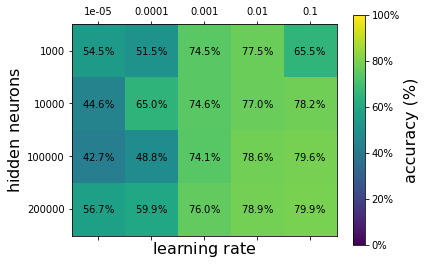

In [8]:
import argparse # handles arguments
import sys; sys.argv=['']; del sys # required to use parser in jupyter notebooks

# Training settings
parser = argparse.ArgumentParser(description='PyTorch SUSY Example')
parser.add_argument('--dataset_size', type=int, default=100000, metavar='DS',
                help='size of data set (default: 100000)')
parser.add_argument('--high_level_feats', type=bool, default=None, metavar='HLF',
                help='toggles high level features (default: None)')
parser.add_argument('--batch-size', type=int, default=100, metavar='N',
                help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.05, metavar='LR',
                help='learning rate (default: 0.02)')
parser.add_argument('--momentum', type=float, default=0.8, metavar='M',
                help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                help='disables CUDA training')
parser.add_argument('--seed', type=int, default=2, metavar='S',
                help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                help='how many batches to wait before logging training status')
args = parser.parse_args()

# set seed of random number generator
torch.manual_seed(args.seed)

grid_search(args)
